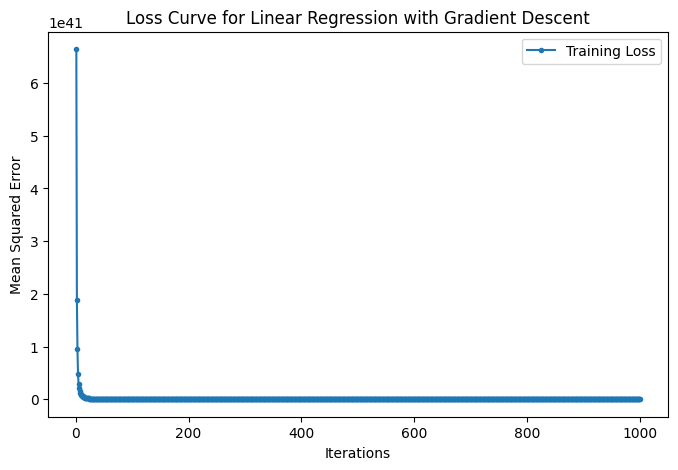

Linear Regression MSE: 6.931226793660895e+35
Decision Tree MSE: 180377041.12002125
Random Forest MSE: 103536893.58122501
Best model saved as 'best_model.pkl'.
Predicted Yield for Maize in Rwanda: 25241.57 hg/ha


c:\Users\TSR\Desktop\Summative\my_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [16]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle  # For saving the model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import gzip

# Step 2: Load Dataset
df = pd.read_csv("yield_df.csv")

# Step 3: Drop Irrelevant Columns
df = df.drop(columns=["Unnamed: 0"])  # Keeping "Area"

# Step 4: Encode Categorical Data (Item & Area columns)
label_encoder_item = LabelEncoder()
df["Item"] = label_encoder_item.fit_transform(df["Item"])

label_encoder_area = LabelEncoder()
df["Area"] = label_encoder_area.fit_transform(df["Area"])

# Step 5: Define Features and Target Variable
X = df[["average_rain_fall_mm_per_year", "pesticides_tonnes", "avg_temp", "Item", "Area", "Year"]]
y = df["hg/ha_yield"]

# Step 6: Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Train Linear Regression with Gradient Descent
lr_model = SGDRegressor(max_iter=1000, learning_rate="optimal", random_state=42)
train_losses = []
for i in range(1000):
    lr_model.partial_fit(X_train, y_train)
    y_train_pred = lr_model.predict(X_train)
    train_losses.append(mean_squared_error(y_train, y_train_pred))

# Plot loss curve with points
plt.figure(figsize=(8, 5))
plt.plot(range(1, 1001), train_losses, label='Training Loss', marker='o', markersize=3, linestyle='-')
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Loss Curve for Linear Regression with Gradient Descent")
plt.legend()
plt.show()

# Step 8: Train Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Step 9: Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 10: Make Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Step 11: Calculate Mean Squared Error (Loss)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_dt = mean_squared_error(y_test, y_pred_dt)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print("Linear Regression MSE:", mse_lr)
print("Decision Tree MSE:", mse_dt)
print("Random Forest MSE:", mse_rf)

# Step 12: Save the Best Model (Random Forest)
with gzip.open("../API/best_model.pkl.gz", "wb") as model_file:
    pickle.dump(rf_model, model_file)

# Save the label encoders (these are small, so no compression needed)
with open("../API/label_encoder_item.pkl", "wb") as model_file:
    pickle.dump(label_encoder_item, model_file)
with open("../API/label_encoder_area.pkl", "wb") as model_file:
    pickle.dump(label_encoder_area, model_file)

print("Best model saved as 'best_model.pkl'.")

# Step 13: Load and Use the Model for Predictions
def predict_yield(rainfall, pesticide, temp, item_name, area_name, year):
    """
    Function to predict crop yield based on inputs.
    :param rainfall: Annual rainfall (mm)
    :param pesticide: Pesticide usage (tonnes)
    :param temp: Average temperature (°C)
    :param item_name: Name of the crop (string)
    :param area_name: Name of the area (string)
    :return: Predicted yield (hg/ha)
    """
    # Load model
    with gzip.open("../API/best_model.pkl.gz", "rb") as model_file:
        model = pickle.load(model_file)

    # Encode Item and Area
    item_encoded = label_encoder_item.transform([item_name])[0]
    area_encoded = label_encoder_area.transform([area_name])[0]

    # Create input array
    input_data = np.array([[rainfall, pesticide, temp, item_encoded, area_encoded, year]])

    # Make prediction
    prediction = model.predict(input_data)
    print(f"Predicted Yield for {item_name} in {area_name}: {prediction[0]:.2f} hg/ha")
    return prediction[0]

# Example usage
predicted_yield = predict_yield(1485, 121, 16.37, "Maize", "Rwanda", 2003)
